##### *Seghe Momodu*
##### *October 30, 2020*

# **1. Experiment Overview**

The Data Science team has built a sorting algorithm and A/B tested it by randomly splitting the traffic.

The new algorithm aims at maximising the Click Through Rate of the products shown on the catalog and category pages of the Mobile App and Website.

The experiment ran from 2020-06-02 and 2020-07-24.

### **Experiment Name**: Sorting Algorithm Experiment

The Business Objective of this experiment is to maximise click through rates (CTR) on the catalog and category pages on the Mobile App and Web pages.

The objective of this analysis is the determine whether or not, the new sorting algorithm B should be deployed.

### **Experiment Details**

Unit of Diversion: The unit of diversion used for this experiment is the platform. This has been chosen as a proxy for a cookie, which is an anonymous identifier. This is based on the assumption that, for a user visible change, it makes sense to assign people as opposed to events. A cookie is known to be assigned to a particular browser or user device.

### **Experiment Hypothesis**

The hypothesis is that the new sorting algorithm would increase the number of products clicked from the products shown on the catalog and category pages of the Mobile App and Website platforms.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2. Data**

#### **Loading the required libraries**

In [2]:
import pandas as pd
import numpy as np
import math
import scipy.stats as st
from scipy import stats
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 5]
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_ab_test = pd.read_excel('/content/drive/MyDrive/Jumia/Jumia Data Scientist Case Study Data/data_ab_test.xlsx', sheet_name = 'data')
data_ab_test.head()

,platform,date,path,catalog_page_type,version,nr_impressions,nr_clicks
0,App,2020-06-19,ecron pc,Search,B,17,1
1,App,2020-06-19,salon,Category,B,0,1
2,Web,2020-06-19,/smartphones-android/iku/,Category,A,165,1
3,App,2020-06-19,gel hydro,Search,A,45,3
4,App,2020-06-19,k rein,Search,B,87,0


In [4]:
# Check for missing values
data_ab_test.isna().sum()

platform             0
date                 0
path                 0
catalog_page_type    0
version              0
nr_impressions       0
nr_clicks            0
dtype: int64

# **3. Analysis**

The unit of diversion is the platform (web or mobile app). This is based on the assumption that each platform is independent. 

*The significance level, alpha (α) is 0.05 or 5%.*

To **sanity check**, I shall check the distribution of interactions per platforms (web and mobile app) for the first two weeks (2020-06-02 to 2020-06-16). 

The original design of the experiment is in a 50-50 split. I shall model the diversions such that, the expected number of interactions in the control version A is about 50% of the total number of interactions. This is to ensure that the distribution of interactions is completely random and not significant in both versions on each platform.

The data for the first two weks of the experiment duration is extracted. This timeline is between 2020-06-02 and 2020-06-15.

In [5]:
data = data_ab_test.loc[data_ab_test['date'].between('2020-06-02', '2020-06-15', inclusive = True)]
data

,platform,date,path,catalog_page_type,version,nr_impressions,nr_clicks
653270,Web,2020-06-02,/haut-parleurs-haut-parleurs-centraux/lt-power/,Category,A,27,2
653271,Web,2020-06-02,/epicerie-papier-plastique/,Category,B,24,0
653272,Web,2020-06-02,/petits-appareils-autres-petits-appareils/taurus/,Category,A,4,0
653273,Web,2020-06-02,/smartphones/condor/,Category,A,163,7
653274,Web,2020-06-02,/sneakers-et-tennis/reebok/,Category,A,2,1
...,...,...,...,...,...,...,...
784327,App,2020-06-15,bran,Category,B,0,1
784328,App,2020-06-15,protection cheuveux,Search,A,8,1
784329,App,2020-06-15,montre in mode femme,Search,A,59,1
784330,App,2020-06-15,havan,Search,B,10,0


## **Invariate Metric: Distribution of Interactions by Version for each Platform.**

In [6]:
df1 = data.groupby(['version', 'platform']).size().unstack()
df1 = df1.reset_index()
df1['platform_count'] = df1['Web'] + df1['App']
df1['platform_distribution'] = df1['platform_count'] / df1['platform_count'].sum()
df1

platform,version,App,Web,platform_count,platform_distribution
0,A,42115,50724,92839,0.708359
1,B,15127,23096,38223,0.291641


In [7]:
# compute the z-score
alpha = 0.05
def get_z_score(alpha):
  x = 1 - (alpha/2)
  return norm.ppf(x)

# probability of success of experiment
p = 0.5

# Calculate proportion of observed fraction of control experiment, A
p_hat = df1.loc[df1['version'] == 'A', 'platform_distribution'].values[0]
total_count = df1['platform_count'].sum()

# SD of binomial with 50% probability of success
stdev = math.sqrt(p * (1 - p) / (total_count))

# Calculate margin of error
margin_error = round(get_z_score(alpha) * stdev, 4)

print('The confidence interval for the control of version B is between {} and {}'.format(p - margin_error, p + margin_error))
print('p_hat is the probability of observed proportion of the control experiment.The p_hat is', p_hat)

The confidence interval for the control of version B is between 0.4973 and 0.5027
p_hat is the probability of observed proportion of the control experiment.The p_hat is 0.7083594024202285


The **p_hat = 0.7083594024202285** is clearly not within the confidence interval.

To troubleshoot this issue, I shall perform a sanity check to ensure that the proportion of the split in the control version, A, is roughly in the same proportion as the experiment version, B.

### **Sanity Check 1: A/B testing for 2 weeks between 2020-06-02 and 2020-06-16**

In [8]:
df1a = data.groupby(['date', 'version']).size().unstack()
df1a['p_hat1_A'] = df1a['A'] / (df1a['A'] + df1a['B'])
df1a['p_hat1_B'] = df1a['B'] / (df1a['A'] + df1a['B'])
df1a['platform_count'] = df1a['A'] + df1a['B']
df1a

version,A,B,p_hat1_A,p_hat1_B,platform_count
date,,,,,
2020-06-02,3822,1776,0.682744,0.317256,5598
2020-06-03,3765,1637,0.696964,0.303036,5402
2020-06-04,3489,1581,0.688166,0.311834,5070
2020-06-05,3529,1512,0.700060,0.299940,5041
2020-06-06,3123,1555,0.667593,0.332407,4678
2020-06-07,3105,1493,0.675294,0.324706,4598
2020-06-08,3368,1592,0.679032,0.320968,4960
2020-06-09,3740,1683,0.689655,0.310345,5423
2020-06-10,4260,1851,0.697104,0.302896,6111


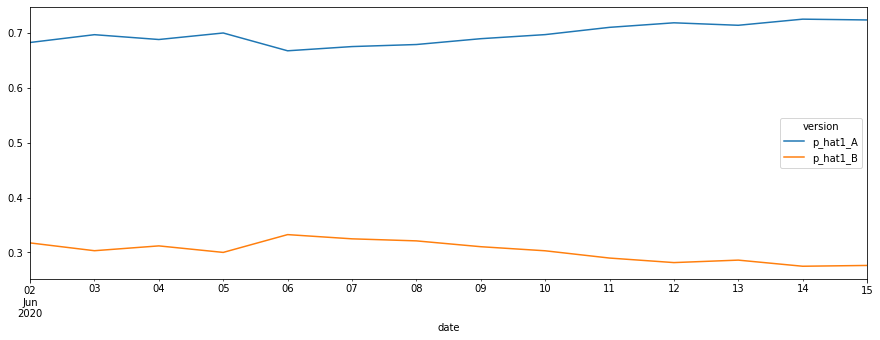

Text(0.5, 1.0, 'Distribution of Platform Interactions per Version between 2020-06-02 and 2020-06-15')

In [9]:
df1_reset = df1a.reset_index()
ax = df1_reset.plot(x = 'date', y = ['p_hat1_A',	'p_hat1_B'])
plt.show()
ax.set_title('Distribution of Platform Interactions per Version between 2020-06-02 and 2020-06-15')

It can be observed from the table above and from the chart that the experiment is not proportionately split according to the experimental design. The data from the experiment between 2020-06-02 and 2020-06-15 shows that the split deviates from the original design. The split within this data range is in a 70% - 30% split.

There may have been a multitude of issues at the time so I shall observe the platform diversions for another date range. 

### **Sanity Check 2: A/B testing for 2 weeks between 2020-06-30 and 2020-07-14**

#### - Unit of Diversion: Platform

In [10]:
data2 = data_ab_test.loc[data_ab_test['date'].between('2020-06-30', '2020-07-14', inclusive = True)]
df2a = data2.groupby(['date', 'version']).size().unstack()
df2a = df2a.reset_index()
df2a['p_hat_A'] = df2a['A'] / (df2a['A'] + df2a['B'])
df2a['p_hat_B'] = df2a['B'] / (df2a['A'] + df2a['B'])
df2a['platform_count'] = df2a['A'] + df2a['B']
df2a

version,date,A,B,p_hat_A,p_hat_B,platform_count
0,2020-06-30,8944,9401,0.487544,0.512456,18345
1,2020-07-01,9003,9217,0.494127,0.505873,18220
2,2020-07-02,8958,9149,0.494726,0.505274,18107
3,2020-07-03,9061,9084,0.499366,0.500634,18145
4,2020-07-04,9000,8905,0.502653,0.497347,17905
5,2020-07-05,9310,9098,0.505758,0.494242,18408
6,2020-07-06,9230,9246,0.499567,0.500433,18476
7,2020-07-07,8822,9005,0.494867,0.505133,17827
8,2020-07-08,8767,8946,0.494947,0.505053,17713
9,2020-07-09,8449,8447,0.500059,0.499941,16896


In [11]:
df2 = data2.groupby(['version', 'platform']).size().unstack()
df2 = df2.reset_index()
df2['platform_count'] = df2['Web'] + df2['App']
df2['platform_distribution'] = df2['platform_count'] / df2['platform_count'].sum()
df2

platform,version,App,Web,platform_count,platform_distribution
0,A,97043,34646,131689,0.497736
1,B,96303,36584,132887,0.502264


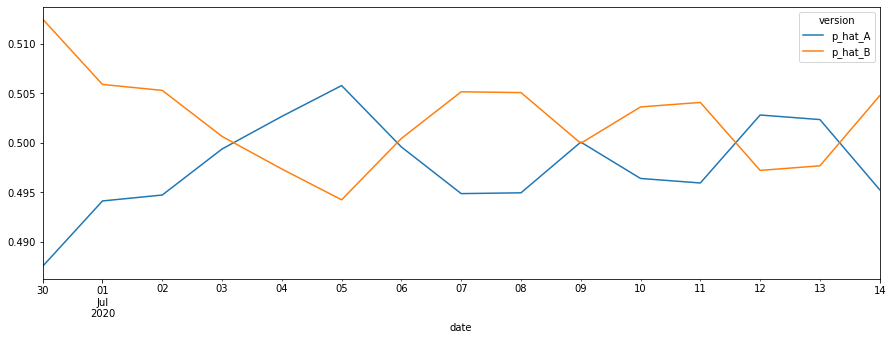

Text(0.5, 1.0, 'Distribution of Platform Interactions per Versions between 2020-06-30 and 2020-07-14')

In [12]:
df2_reset = df2a.reset_index()
ax = df2_reset.plot(x = 'date', y = ['p_hat_A',	'p_hat_B'])
plt.show()
ax.set_title('Distribution of Platform Interactions per Versions between 2020-06-30 and 2020-07-14')

The data for this date range is observed to be in line with the original design of the experiment. The data is proportionately in a 50% - 50% split (approximately 49.8% - 50.2%).

#### Checking Invariants

In [13]:
# compute the z-score
alpha = 0.05
def get_z_score(alpha):
  x = 1 - (alpha / 2)
  return norm.ppf(x)

# probability of success of experiment
p = 0.5

# Calculate proportion of observed fraction of control version, A
p_hat2 = df2.loc[df2['version'] == 'A', 'platform_distribution'].values
total_count = df2['platform_count'].sum()

# SD of binomial with 50% probability of success
stdev = math.sqrt(p * (1 - p) / (total_count))

# Calculate margin of error
margin_error = round(get_z_score(alpha) * stdev, 4)

# Check that the observed fraction is within the Confidence Interval.
print('The confidence interval for the control of version A is between {} and {}'.format(p - margin_error, p + margin_error))
print('{} is approximate to the observed proportion of the control experiment.'.format(p_hat2))

The confidence interval for the control of version A is between 0.4981 and 0.5019
[0.497736] is approximate to the observed proportion of the control experiment.


## **Evaluation Metric: Click Through Rate (CTR)**

A comparison between the click through rate (CTR) of version A and version B is made and the confidence interval is calculated for the difference whether or not the confidence interval is statistically significant.

Click through rate (CTR) refers to the percentage of people that click on an element that they have been exposed to. Click through rate is calculated by simply dividing the number of clicks by the number of impressions.

In [14]:
# The observations where the number of impressions is equals to 0 are ignored.
data2i = data2.loc[data2['nr_impressions'] != 0]
data2i['CTR'] = data2i['nr_clicks'] / data2i['nr_impressions']
data2i

,platform,date,path,catalog_page_type,version,nr_impressions,nr_clicks,CTR
234862,App,2020-06-30,jeux-video-jeux-video,Category,B,205,3,0.014634
234863,Web,2020-06-30,/exercice-remise-en-forme-costumes-sauna/,Category,B,27,1,0.037037
234864,App,2020-06-30,sale de bain,Search,A,622,2,0.003215
234865,App,2020-06-30,iphon,Search,B,78,1,0.012821
234866,Web,2020-06-30,/coffret-maquillage/bourjois--brand-farmasi--e...,Category,A,10,0,0.000000
...,...,...,...,...,...,...,...,...
499431,App,2020-07-14,panneau solaire,Search,A,20,0,0.000000
499432,Web,2020-07-14,/pc-gamers-graphistes/glorious/,Category,B,22,0,0.000000
499433,App,2020-07-14,v√™tements v√™tements femme,Search,B,110,1,0.009091
499435,App,2020-07-14,boule de neige,Search,B,33,0,0.000000


In [15]:
data2ia = data2i.groupby('version')['nr_clicks', 'nr_impressions'].sum()
data2ia = data2ia.reset_index()
data2ia['CTR'] = data2ia['nr_clicks'] / data2ia['nr_impressions']
data2ia

,version,nr_clicks,nr_impressions,CTR
0,A,278091,39707495,0.007003
1,B,305193,43246671,0.007057


From above table, it is observed that the number of interactions (nr_clicks and nr_impressions) in version A and version B are approximate to 50% - 50% (exactly 48% - 52%) respectively. The overall CTR of version B is slightly higher than version A (0.77% relative increase).To check that this increase is statistically significant I shall calculate the p_value of the difference in the CTR for the two versions and test whether or not the difference is statistically significant.

The test statistic used is the comparison between the click through rates of version A and version B. A z-test will be conducted to calculate the p-value. 

#### **Hypothesis**

- **H0**: Page visitors that receive version B will not have a higher CTR compared to visitors that receive version A.
- **H1**: Page visitors that receive version B will have a higher CTR compared to visitors that receive version A.

In [16]:
# Number of clicks in version A and version B
nr_clicks_A = data2ia.loc[data2ia['version'] == 'A', 'nr_clicks'].values
nr_clicks_B = data2ia.loc[data2ia['version'] == 'B', 'nr_clicks'].values

# Number of impressions in version A and version B
nr_impressions_A = data2ia.loc[data2ia['version'] == 'A', 'nr_impressions'].values
nr_impressions_B = data2ia.loc[data2ia['version'] == 'B', 'nr_impressions'].values

# Click through rates in version A and version B
CTR_A = data2ia.loc[data2ia['version'] == 'A', 'CTR'].values
CTR_B = data2ia.loc[data2ia['version'] == 'B', 'CTR'].values

# Calculate the pooled click through rates of version A and version B
CTR_pooled = (nr_clicks_A + nr_clicks_B)/(nr_impressions_A + nr_impressions_B)

# Calculate the pooled standard deviation
CTR_stdev_pooled = math.sqrt(CTR_pooled * (1 - CTR_pooled) * (1 / nr_impressions_A + 1 / nr_impressions_B))

# Calculate the margin of error
CTR_ME = round(get_z_score(alpha) * CTR_stdev_pooled, 5)
CTR_diff = np.round(CTR_B - CTR_A, 4)

# Calculate the z-score
z = ((CTR_B - CTR_A) - 0) / CTR_stdev_pooled

# Calculate the p_value 
p_value = 2 * (1 - st.norm.cdf(z))

# Check that the observed change due to the experiment is within the Confidence Interval 
print('The p-value is', p_value)
print('The change due to the experiment is', list(map('{:.4f}'.format, CTR_diff)))
print('The Confidence Interval of difference:', list(map('{:.5f}'.format, CTR_diff - CTR_ME,)), 'to', list(map('{:.5f}'.format,CTR_diff + CTR_ME)))

The p-value is [0.00355357]
The change due to the experiment is ['0.0001']
The Confidence Interval of difference: ['0.00006'] to ['0.00014']


Since the **p_value < 0.05**, the Null hypothesis (H0) is rejected because a low p_value of 0.00355357 indicates a strong evidence that page visitors that receive version B will have a higher click through rate compared to those that received version A.

Therefore, I shall reject the Null hypothesis (H0) and fail to reject the Alternative hypothesis (H1). This indicates that the results are completely random and thus statistically significant.



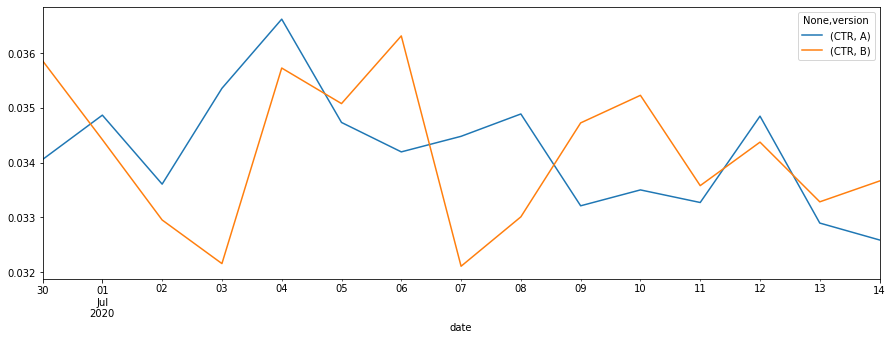

Text(0.5, 1.0, 'Click Through Rates between 2020-06-30 and 2020-07-14')

In [17]:
df_CTR = data2i.groupby(['date', 'version']).agg({'CTR': np.mean}).unstack().reset_index()
ax = df_CTR.plot(x = 'date', y = ['CTR'])
plt.show()
ax.set_title('Click Through Rates between 2020-06-30 and 2020-07-14')

The click through rate between 2020-06-30 and 2020-07-14 supports our results. It can be observed that there are occurences where the click through rates of version B is higher than the CTR of version A.

To validate the results, the CTR for another two-week range shall be observed.

In [18]:
data3 = data_ab_test.loc[data_ab_test['date'].between('2020-07-11', '2020-07-24', inclusive = True)]
data3i = data3.loc[data3['nr_impressions'] != 0]
data3i['CTR'] = data3i['nr_clicks'] / data3i['nr_impressions']
df_CTR1 = data3i.groupby(['date', 'version']).agg({'CTR': np.mean}).unstack().reset_index()

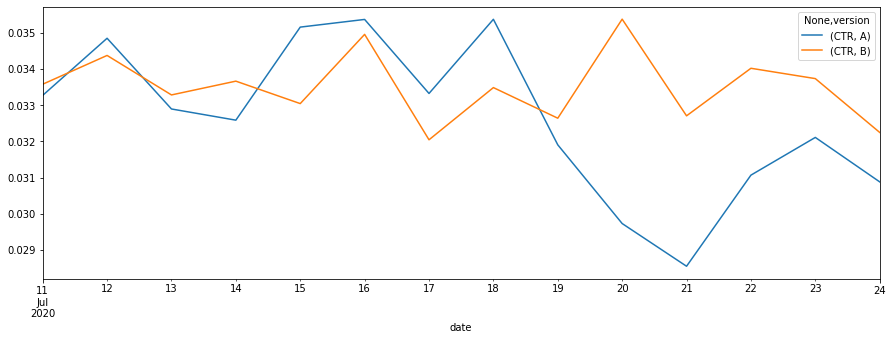

Text(0.5, 1.0, 'Click Through Rates between 2020-07-11 and 2020-07-24')

In [19]:
ax = df_CTR1.plot(x = 'date', y = ['CTR'])
plt.show()
ax.set_title('Click Through Rates between 2020-07-11 and 2020-07-24')

The click through rates between 2020-07-11 and 2020-07-24 validates our results! There are definitely occurences where the click through rates of version B is significantly higher than the CTR of version A.

# **4. Recommendations and Conclusions**


The A/B test for the new sorting algorithm was run successfully according to design specifications.

#### **Conclusions**

From the analysis of the metrics, the following conclusions can be made:

- **Page visits for version B showed a statistically significant change in click through rates than page visits for version A.**
- **Page visits for version B showed randomly higher click through rates than page visits for version A.**
- **The new sorting algorithm observedly led to higher click through rates in page visits of version B.**

#### **Recommendations**

Based on the results of the analysis of page visits between version A (control) and the version B (experiment), the following recommendation can be made:

**The new sorting algorithm should be deployed as it increases the click through rates of product shown on the catalog & category pages of our Mobile App and Web platforms.**